<img src="img/ENSAE_logo.jpg">

# *ELTDM Project*
# *Parallelised Community Detection with Spark MapReduce*  
**Mastère Spécialisé Data Science, 2018-19, "Éléments logiciels pour le traitement des données massives"** 
  
**Alban CHAMPEVILLE DE BOISJOLLY**   
**Yosuke IJIRI**  
  

## Abstract

This project implements a parallelised community detection algorithm proposed by [*Moon, et al. (2015)*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. For parallelisation, we run Spark using Python on our dual-core laptop with 4 logical CPUs, which can easily be adapted for scaling out to process much larger datasets with cloud environments such as AWS and Microsoft Azure.

## Overview

In [289]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Introduction & Literature Review

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. In Data Science, K-mean clustering and community detection method are the two main approaches to analyse networks in applications such as anomaly detection and recommendation system.

In our project, we employ community detection which allows us to identify clusters in a graph network with nodes and edges by regrouping nodes into groups of densely connected nodes.

<img src="img/network.png" width="400" align="left">

Community detection is a process to partition the set of network nodes into multiple groups such that the nodes within a group are connected densely, but connections between groups are sparse. Popular algorithms of community detection include Girvan-Newman, Louvain and Walktrap. Other popular algorithms and methodologies are compared in [*Algesheimer, et al. (2016)*](https://www.nature.com/articles/srep30750).

The Girvan-Newman algorithm [(*Girvan and Newman (2004)*)](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf) exploits the concept of edge betweenness, a measure of the centrality and influence of an edge in a network. The edges connecting communities are expected to have high edge betweenness. The underlying community structure of the network will be much clear after removing edges with high edge betweenness. For the removal of each edge, the calculation of edge betweenness is $\mathcal{O}(EN)$; therefore, this algorithm’s time complexity is $\mathcal{O}(E^2N)$ (with E edges and N nodes). There are two major definitions of edge betweenness: shortest-path betweenness and random-walk betweenness.

We find the shortest paths between all pairs of nodes and count how many run along each edge. *Girvan and Newman (2004)* suggest that *"for most problems, we recommend the algorithm with ... shortest-path betweenness measure ... This measure appears to work well and is the quickest"* and that *"The other versions ... make greater computational demands, and in practice seem to give results no better than the shortest-path method"*. The random-walk betweenness which requires to calculate how often on average random walks starting at node s will pass down a particular edge from node v to node w (or vice versa) before finding their way to a given target node t. But it cannot produce a local maximum in the modularity unlike the shortest-path method.

The Louvain algorithm [(*Blondel et al. (2008)*)](https://pdfs.semanticscholar.org/b434/c0199bbf38163abd5f995e76aa1619d39db9.pdf), which looks first for "small" communities by optimizing modularity locally. It aggregates in a second time nodes belonging to the same community and builds a new network whose nodes are the communities. These 2 steps are repeated iteratively until a maximum of modularity is reached and a hierarchy of communities is produced. This method allows community detections on networks of 2 million nodes within 2 minutes on a standard PC.

The Walktrap [(*Pons and Latapy (2005)*)](https://www-complexnetworks.lip6.fr/~latapy/Publis/communities.pdf) method utilises that random walkers tends to get ‘trapped’ into more densely connected group.

Although the Girvan-Newman algorithm with shortest-path betweenness methodology is proved to be one of the most efficient community detection algorithm, it has limitations in supporting large-scale networks since it needs to calculate the shortest path between every pair of nodes which lead Newman and Girvan to mention in 2004 *"In our experience, this typically makes it tactable for networks of up to about n=10000 nodes, with current desktop computers."*.

In this context, and given the expanding size of networks today, parallelisation of calculation is key to realize the task efficiently, and thus our work is focused on the MapReduce version of Girvan-Newman algorithm based on shortest-path betweeness which allows us to process large network data. In the model, that is explained in the next section, each of the 4 stages contains Map-Reduce functions parallelized on machine's threads.

## 2. Model

- The MapReduce shortest-path betweenness Girvan-Newman algorithm processes data in four stages. Tuples output of a stage are chained to the input of the next stage. Each stage executes its own map and reduce tasks. An iteration of these four stages produces a community detection result. In each iteration, Stage1 is executed multiple times, and the other stages are executed only once. The four stages repeat until the result quality no longer improves. This quality is measured by a modularity Q (method detailed in this notebook). We run the model until the value of Q obtains a negative value; the best community structure is determined at the point where the quality of communities does not improve any more.


- A tuple of 7 elements is maintained for each pair of nodes in the process of community detection. It holds the network structure (i.e., an adjacency list), the shortest path obtained so far, and so on:
    - **targetId** indicates the destination node of a shortest path and is initially set to be sourceId.
    - **sourceId** indicates the source node of a shortest path and is initially set to be targetId.
    - **distance** indicates the length of a shortest path and is initially set to be 0. The value of distance is updated in each iteration of Stage 1.
    - **status** indicates the status of a specific path. a is “active”, and i is “inactive” meaning that the shortest path is already detected.
    - **weight** indicates the number of the shortest paths from sourceId to targetId and is initially set to be 1.
    - **pathInfo** indicates the list of the nodes on a shortest path and is initially set to be null.
    - **adjList** indicates the list of the nodes adjacent to targetId.

### 2.1. Algorithm

- The algorithm is splited in 4 stages executed sequentially:

    - [Stage 1]: finds all pair shortest paths (Breadth-first search). In short, each round of this algorithm cuts $k_{itr}$ (= 1 by default) edges based on shortest path betweenness, and measures the strength (modularity) of its community structure.
    - [Stage 2]: calculates edge betweenness. Total weight of edges are computed given their importance in shorter paths between 2 nodes.
    - [Stage 3]: selects the edges to be removed. $k_{itr}$ edges are selected according to edge betweenness. $k_{itr}$ can be specified by a user as a tuning parameter. One in the case of our Notebook.
    - [Stage 4]: removes the edges. Edges selected by Stage 3 are removed from the network. This will impact edge betweeness in next iterations.

- At the end of Stage 4 of each round, the strength (Q) of its community structure is measured. The best community division can be found at the round that gives the largest value of Q.

- The pseudocode of Girvan-Newman Algorithm with MapReduce is described below.

<img src="img/algo.png" width="450" align="left">

### 2.2. Data
- We have 7 network datasets with different number of nodes and edges.
    - test.txt: 21 nodes, 31 edges [(Source: Newman and Girvan (2004))](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf)
    - soc-karate.txt: 34 nodes, 78 edges [(Source: Mark Newman's web page)](http://www-personal.umich.edu/~mejn/netdata/)
    - Test100.txt: 103 nodes, 239 edges
    - soc-ANU-residence_without_weights.txt: 217 nodes, 1839 edges
    - soc-physicians.txt: 241 nodes, 923 edges
    - ca-GrQc_small.txt: 639 nodes, 617 edges
    - email-Eu-core.txt: 986 nodes, 16064 edges [(Source: Stanford Large Network Dataset Collection)](https://snap.stanford.edu/data/)  
(Some of the datasets are pre-processed in order to be adapted for our algorithm and purpose.)


- Among those, we use "soc-karate" data as our benchmark. This dataset is from Zachary’s Karate Club data (Zachary 1977), which describes social network friendships between 34 members of a karate club at a U.S. university in the 1970s. This is one of the standard publicly available data sets for testing community detection algorithms. It contains 34 nodes (members) and 78 links (friendships). NodeId=1 is a part-time instructor and nodeId=33 is the captain of the club. There was a split in the club due to the difference of opinion on the club management between the instructor and the captain.

### 2.3. Environment
We run Spark using Python on our dual-core laptop with 4 logical CPUs (hyper-threading technology).

- Specification  
    - Hardware: MacBook Pro (Mid 2014)  
    - OS: macOS Mojave, Version 10.14.3
    - CPU: Intel(R) Core(TM) i5-4278U CPU, 2.6GHz, dual core
    - Memory: 8GB 1600 MHz DDR3  
- Language: Python
- Parallelisation method: Spark (pyspark)



## 3. Implementation

In [123]:
# Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
from operator import add
from copy import deepcopy
import time
from IPython.display import HTML
from pyspark import SparkContext, SparkConf

- We have 7 network datasets with different number of nodes and edges.

In [124]:
# Load a dataset from the 7 options

#file = 'test.txt'  # 21 nodes,31 edges
file = 'soc-karate.txt'  # 34 nodes,78 edges
#file = 'Test100.txt'  # 103 nodes,239 edges
#file = 'soc-ANU-residence_without_weights.txt'  # 217 nodes, 1839 edges
#file = 'soc-physicians.txt'  # 241 nodes, 923 edges
#file = 'ca-GrQc_small.txt'  # 639 nodes, 617 edges
#file = 'email-Eu-core.txt'  # 986 nodes, 16064 edges

data = np.loadtxt('./Data/' + file, dtype='uint16')

print(type(data))
print(data[:5])  # Display the first 5 rows of the loaded dataset

<class 'numpy.ndarray'>
[[2 1]
 [3 1]
 [4 1]
 [5 1]
 [6 1]]


In [127]:
# Define dictionaries to store execution time histories.
# We use them in 4. Result and Discussion to draw result graphs.
try:  # Do nothing if these variables are already defined
    stage_time_dict
    total_time_dict
except NameError:
    stage_time_dict = {}
    total_time_dict = {}

<a id='Spark Configuration'></a>

### 3.1. Spark Configuration
- We first start SparkContext by specifying the number of threads to be used.
- (After running this cell, in case of re-execution, re-execute from <a href='#Adjacency List Creation'>here</a>.)

In [275]:
# Stop SparkContext if it is already running
try:
    sc.stop()
except NameError:
    pass

configuration = (SparkConf()
        .setMaster("local[6]")  # Specify the number of threads to be used
        .setAppName("ELTDM")
        .set('spark.executor.memory', '1g')
        .set('spark.driver.memory', '1g')
        .set('spark.driver.host', 'localhost'))
sc = SparkContext(conf = configuration)
nb_thread = sc.defaultParallelism
sc

<SparkContext master=local[6] appName=ELTDM>

In [235]:
sc.defaultParallelism

6

In [236]:
sc._conf.getAll()

[('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'ELTDM'),
 ('spark.driver.port', '60442'),
 ('spark.app.id', 'local-1550621761231'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'localhost'),
 ('spark.driver.memory', '1g'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.master', 'local[6]')]

### 3.2. Data Preparation
- Before proceeding, we clean up the dataset (edge list) according to the below three criteria:
    1. Put the node with smaller ID to the left for each edge data (e.g. [3 1] -> [1 3]) (undirectional network)
    2. Filter out self-edge data (e.g. [2 2] -> delete)
    3. Remove duplicate edges

In [160]:
# Clean up the edge list
rdd = sc.parallelize(data)
d = rdd.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]  # Criterion 1
           ).filter(lambda x: x[0] != x[1]).collect()  # Criterion 2
d = list(set(map(tuple, d)))  # Criterion 3
d = list(map(list, d))
print(type(d))

<class 'list'>


In [161]:
# Save the original node&edge information
nodes = list(set([n1 for n1, n2 in d] + [n2 for n1, n2 in d]))
nb_edges_initial = len(d)

print('The data contains %d distinct nodes, and %d distinct edges' % (len(nodes), nb_edges_initial))

The data contains 34 distinct nodes, and 78 distinct edges


- Let's visualise the initial network of the dataset.
- We can confirm that the nodeId=1 (instructor) and nodeId=33 (captain), the leader of each of the two factions, have many edges (friendships) connected to other nodes (members).

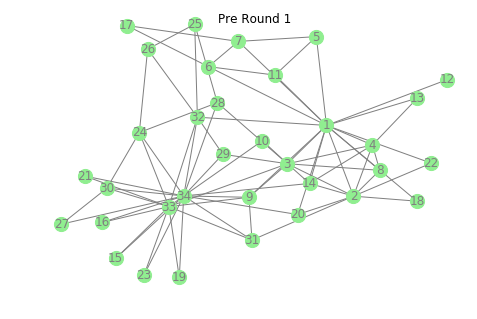

In [273]:
# Visualisation of the graph
n_size = 200  # Set the size of the nodes in the graph

def draw_initial_graph(graph):
    
    # Create networkx graph
    G=nx.Graph()
    
    # Add nodes
    for node in nodes:
        G.add_node(node)
        
    # Add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
        
    # Save the positions of the nodes
    pos=nx.get_node_attributes(G,'pos')

    # Configure the graph
    pos = nx.spring_layout(G)
    nx.draw(G, 
            pos, 
            with_labels = True, 
            node_size = n_size,
            node_color = 'lightgreen', edge_color = 'gray', font_color = 'gray')
    
    # Save and display the graph
    plt.suptitle('Pre Round 1')
    plt.savefig('./Data/Figures/Post_Round_00.png')
    plt.show()
    plt.close()
    return pos

np.random.seed(seed=97)
pos = draw_initial_graph(d)  # Save the initial node positions

<a id='Adjacency List Creation'></a>

(In case of re-execution, run the below 3 cells.)

In [276]:
# Make a list of adjacency lists
# The first element of each adjacency list denotes the node of origin
adj_list = []

for n in nodes:
    
    adj = []

    # If a node in a edge data is the origin (n),
    # add the connected node to its adjacency list
    for i in range(len(d)):
        if d[i][0] == n:
            adj.append(d[i][1])
        if d[i][1] == n:
            adj.append(d[i][0])
    
    adj = list(set(adj)) 
    adj.insert(0, n)  # Label the adjacency list with the node ID of origin
    adj_list.append(adj)

print('Sample: Adjacency list of origin node ID %d is %s' %(adj_list[0][0], adj_list[0]))

Sample: Adjacency list of origin node ID 1 is [1, 32, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22]


- The format of tuple is : (targetId, sourceId, distance, 'status', weight, [pathInfo], [adjList])

In [277]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []

for n in nodes:
    
    # Create tuples
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    
    # Fill in adjList
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
            
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])

print('Sample: the first tuple is %s' %network[0])

Sample: the first tuple is [1, 1, 0, 'a', 1, [], [32, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22]]


- Although it is not necessary to convert the input of the initial Stage1 Map into key-value format, we make this conversion in order to be able to put the output of the Stage4 Reduce directly to the Stage1 Map of the next round.

In [278]:
# Key-value conversion
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

(In case of re-execution, go to <a href='#Rounds Stage1-4'> 3.8. Rounds Stage1-4</a>)

### 3.3. Stage 1
- In this stage, the shortest paths between every pair of nodes in the network are calculated.
- This Map-Reduce stage (stage 1) repeats until all tuples have 'i' (inactive) for status.
- The outcome of the iteration of this stage should give a list of tuples which tells the shortest paths between every pair of nodes in the network.


#### Map 

- In the Map operation, the frontiers are expanded from every node to its adjacent nodes.
- If $status$ is 'a' (active), status is changed to 'i' (inactive), 1 is added to $distance$ and $targetId$ is added to $pathInfo$.
- In addition, new active tuples are generated by assigning each node in $adjList$ to $targetId$, with $distance$ and $pathInfo$ equal to those of the original tuple.
- Thus, this Map is characterised by **Breadth First Search**.

In [138]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result

#### Reduce 

- In this Reduce operation, among the tuples sharing $sourceId$ and $targetId$, only the tuple that has the minimum value of distance survices.
- If two or more tuples have the same minimum, $weight$ is changed to the number of such tuples to remember the multiplicity of the shortest path.
<br />
<br />
- This Reduce part consists of 6 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples  
6) Fill in any empty adjList

In [139]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)

In [140]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x

In [141]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v

### 3.4. Stage 2
- In this stage, the edge betweenneses of all eadges in the network are calculated.

#### Map & Reduce
- In the Map operation, unity is divided to each edge on a shortest path according to the $weight$ of the shortest paths sharing $sourceId$ and $targetId$.
- In the Reduce operation, the contribution of each shortest path is summed up for each stage.

In [142]:
def stage2_map(x):
    edges_on_the_path = []
    for i in range(len(x[1][4])-1):
        k = (x[1][4][i], x[1][4][i+1])
        w = x[1][3]
        edges_on_the_path.append((k, 1/w))
    return edges_on_the_path

### 3.5. Stage 3
- In this stage, $k_iter$ edges are selected according to edge betweenness. By default, $k_iter = 1$.

#### Map & Reduce

- There is no function to be defined here.
- Refer to Stage3 of <a href='#Rounds Stage1-4'>4.8. Rounds Stage1-4</a>.

### 3.6. Stage4
- In this stage, the edges selected by Stage 3 are removed from the network. Then, a new set of tuples are generated to reflect the removed edges since edge betweenness needs to be recalculated in the next round.

#### Map

In [143]:
def stage4_map(x):
    counter = 0
    output = []
    for i in range(len(distributed_cache)):
        if x[0] in distributed_cache[i][0]:
            counter += 1  # Increase counter if its key is affected by the removal of the edge(s)
            c = distributed_cache[i][0][not(distributed_cache[i][0].index(x[0]))]  # Take the corresponding node
            try:
                x[1][5].remove(c)  # Remove if the corresponding node exists in the adjList
            except ValueError:
                pass  # Pass otherwise
    if counter == 0:
        return [tuple(x)]
    else:
        new = (x[1][0], [x[1][0], 0, 'a', 1, [], []])
        return x, new

#### Reduce

In [144]:
def stage4_reduce(x, y):
    if x[2] == 'a' and y[2] == 'a':
        return x
    elif x[2] == 'a' and y[2] == 'i':
        x[5] = y[5].copy()
        return x
    elif x[2] == 'i' and y[2] == 'a':
        y[5] = x[5].copy()
        return y
    else:
        return x+y
def revision(x):  # To flatten the pressed tuples (ones with status i)
    tup = []
    if len(x[1]) > 6:
        for i in range(int(len(x[1])/6)):
            tup.append((x[0],x[1][i*6:i*6+6]))
        return tup
    else:
        return [x]

In [145]:
def from_tuples_to_edgelist(x):
    res = []
    for i in range(len(x)):
        for j in range(len(x[i][1][5])):
            res.append([x[i][0], x[i][1][5][j]])
    res = set(map(tuple, res))  # Remove duplicate edges
    res = list(res)
    result = list(map(list, res))
    return result

In [274]:
#Visualisation of the graph
r = 1
def draw_graph(graph, r):
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    nx.draw(G, pos = pos, with_labels = True, node_size=n_size, node_color="lightgreen", edge_color='gray', font_color='gray')
    # show graph
    t = float(time.time())
    plt.suptitle('Post Round ' + str(r))
    plt.savefig('./Data/Figures/Post_Round_%02d.png' %r)

### 3.7. Modularity Q
- In order to measure the goodness of a community we find, we employ Modularity Q proposed by [*Girvan and Newman (2004)*.](http://www.cse.cuhk.edu.hk/~cslui/CMSC5734/newman_community_struct_networks_phys_rev.pdf)

- Modularity Q measures the strengh of the community structure of the network. We use the following definition of modularity among several options:

$$Q=\sum_{i}\{e_{ii}-(\sum_{j}e_{ij})^2\} = \mathrm{Tr}\ {\bf e} - \|{\bf e}^2\|$$

- Where “e” is a symmetric matrix of k communities, whose element eij is the fraction of all edges in the network that link nodes in community i to nodes in community j. This quantity Q measures the fraction of the edges in the network that connect nodes in the same community (Tr e), i.e. within-community edges, minus the expected value of the same quantity in a network with the same community divisions but random connections between the nodes ||e²||. 
- If the number of within-community edges is no better than random, we will get Q=0. Values approaching Q=1, which is the maximum, indicate networks with strong community structure. In practice, values for such networks typically fall in the range from about 0.3 to 0.7. Higher values are rare. 
- We will calculate Q for each split of a network into communities and look for local peaks in its value, which indicate particularly satisfactory splits.

In [147]:
def Q_modularity(elist, nodes):

# Read and clean up edges
    c = sc.parallelize(elist)
    c = c.map(lambda x: x if x[0] < x[1] else [x[1], x[0]])\
        .filter(lambda x: x[0] != x[1])\
        .collect()  # Put a smaller ID to the left of the edge and remove self-connecting edge
    c = set(map(tuple, c))  # Remove duplicate edges
    c = list(c)
    c = list(map(list, c))

# Make a graph for NetworkX library
    H=nx.Graph()
    # add nodes
    for node in nodes:
        H.add_node(node)
    # add edges
    for edge in c:
        H.add_edge(edge[0], edge[1])

# Make a community dictionary from the edge list {nodeId: communityId}
    com_dic = {}
    com_id = 0

    for n in nodes:
        try:
            com_dic[n]
        except KeyError:
            com_id += 1
            com_dic[n] = com_id
            for m in nodes:
                if (n != m) and (nx.has_path(H, m, n)):  # has_path(G, source, target) returns True if a path exists
                    try:
                        com_dic[m]
                    except KeyError:
                        com_dic[m] = com_id

    com_ids = list(set(com_dic.values()))
    com_ids

# Create a matrix `e` to calculate Q
    e = np.matrix([[0.]*len(com_ids)]*len(com_ids))

# Fill in `e` 
    for i in range(len(com_ids)):
        for j in range(len(com_ids)):
            keys_i = [k for k, v in com_dic.items() if v == i+1]
            keys_j = [k for k, v in com_dic.items() if v == j+1]
            if i == j:  # Fraction of edges that are within the same community
                nb_within = 0
                for edge in c:
                    if set(edge) <= set(keys_i):
                        nb_within += 1
                e[i, i] = nb_within/nb_edges_initial
            elif i < j:  # Fraction of edges that cross between community i and community j
                nb_cross = 0
                for edge in d:
                    if (({edge[0]} <= set(keys_i)) and ({edge[1]} <= set(keys_j))) or (({edge[0]} <= set(keys_j)) and ({edge[1]} <= set(keys_i))):
                        nb_cross += 1
                e[i, j] = nb_cross/nb_edges_initial
                e[j, i] = nb_cross/nb_edges_initial

    a = np.ndarray.sum(e, axis=1)  
    a = np.squeeze(np.asarray(a))

# Calculate Q 
    Q = float(e.trace()) - np.dot(a, a)

    return Q, com_dic

<a id='Rounds Stage1-4'></a>

### 3.8. Rounds Stage1-4
- Finally we run the code using the functions defined above.
- One round means one iteration over the Stage 1-4.

(In case of re-execuiton, click 'Cell' then 'Run All Below')

Data contains 34 nodes, and 78 edges.
nb_thread = 6 

ROUND 1 STARTED!
  Stage 1 iteration 7 finished. There are 0 / 3146 active tuples left.          
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 1 took 7.7 seconds ( 0.1 mins ).
  ( Q: 0.012656147271531859 , Removed edge(s):  [((1, 32), 71.39285714285714)] )

ROUND 2 STARTED!
  Stage 1 iteration 8 finished. There are 0 / 3232 active tuples left.           
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 2 took 11.4 seconds ( 0.2 mins ).
  ( Q: 0.024983563445101886 , Removed edge(s):  [((1, 3), 66.89517704517704)] )

ROUND 3 STARTED!
  Stage 1 iteration 8 finished. There are 0 / 3424 active tuples left.          
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 3 took 12.9 seconds ( 0.2 mins ).
  ( Q: 0.03698224852071008 , Removed edge(s):  [((1, 9), 77.31739926739925)] )

ROUND 4 STARTED!
  Stage 1 iteration 8 f

  Stage 1 iteration 4 finished. There are 0 / 374 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 28 took 16.0 seconds ( 0.3 mins ).
  ( Q: 0.1725838264299802 , Removed edge(s):  [((1, 13), 5.5)] )

ROUND 29 STARTED!
  Stage 1 iteration 5 finished. There are 0 / 374 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 29 took 17.7 seconds ( 0.3 mins ).
  ( Q: 0.1487508218277449 , Removed edge(s):  [((4, 13), 8.0)] )

ROUND 30 STARTED!
  Stage 1 iteration 4 finished. There are 0 / 352 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished..  Stage 4 finished..
  Round 30 took 16.7 seconds ( 0.3 mins ).
  ( Q: 0.1476002629848785 , Removed edge(s):  [((23, 33), 5.0)] )

ROUND 31 STARTED!
  Stage 1 iteration 4 finished. There are 0 / 336 active tuples left.         
  Stage 1 finished..  Stage 2 finished..  Stage 3 finished.

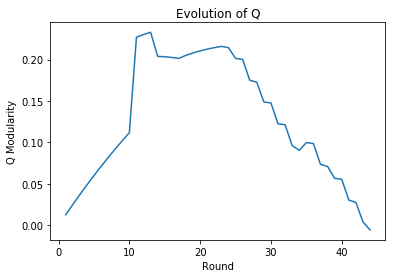

Maximum Q was achieved at round 13 and its value was 0.23290598290598286 .

The best community structure is:
 {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
  ({<Node ID>: <Community ID>}) and there are 2 communities.
The graph at the best was:


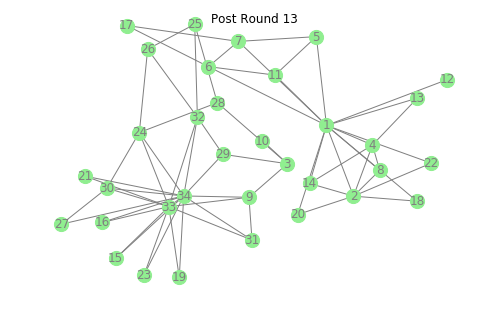

It took 321.9 seconds ( 5.4 mins ) until the network reached the best community structure.


In [279]:
# Iteration of Stage1-4
print('Data contains', len(nodes), 'nodes, and', nb_edges_initial, 'edges.')
print('nb_thread =', nb_thread, '\n')

# Parameter initialisation
k_iter = 1  # Number of edges to be removed at each round. The default value is 1.
r = 1  # Round
t_initial = time.time()
removed_edges=[]
Q = 0
Q_hist = []
elist_hist = []
community_hist = []
t_hist, t_hist_st1, t_hist_st2, t_hist_st3, t_hist_st4, t_hist_round = [], [], [], [], [], []
t_ac1, t_ac2, t_ac3 = 0, 0, 0

# Loop the rounds as long as Q is positive
while Q >= 0:
    print("ROUND", r, "STARTED!")
    
# Stage1
    t_start = time.time() 
    t_st1_start = time.time()
    # Iteration until status becomes 'i' for all tuples
    act_counter = 1
    ite = 1
    while act_counter > 0:  # Repeat Stage1 until all the tuples become inactive state
        #print("Iteration", ite, "started...")
        rdd = sc.parallelize(output)#.repartition(sc.defaultParallelism * 3)

    # <stage1 map>
        #print(" Now doing Map..")
        pos_map1 = rdd.flatMap(stage1_map)
    # <stage1 reduce>
        #print(" Now doing Reduce..")
        red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
        red1_grouped = red1_twokeys.reduceByKey(join)
        red1_weighted = red1_grouped.map(stage1_reduce)
        #print(" Now collecting Reduce result..")
        t1 = time.time()
        record = red1_weighted.map(twokeys_to_onekey).collect()
        t2 = time.time()
        t_ac1 += t2-t1
    # [Checkpoint1]
        #print("    [Checkpoint1] Collecting Map&Reduce result took", round(t2-t1, 1), "seconds (", round((t2-t1)/60, 1), "mins ).")
        #print(" Now flattening Reduce result..")
        t3 = time.time()
        
        # for-loop to flatten the grouped values (non-parallelized)
        new = []
        for i in range(len(record)):
            if type(record[i][1][1]) is list:
                record[i]
                key = record[i][0]
                srcId = [record[i][1][0]]
                others = record[i][1][1:]
                for j in range(len(others)):
                    s = srcId.copy()
                    o = others[j]
                    s.extend(o)
                    newrec = (key, s)
                    new.append(newrec)
        pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  # Save records with only one value
        pos_red1.extend(new)  # Add records which had multiple values
        output = pos_red1.copy()
        t4 = time.time()
        t_ac2 += t4-t3
    # [Checkpoint2]
        #print("    [Checkpoint2] Flattening took", round(t4-t3, 1), "seconds (", round((t4-t3)/60, 1), "mins ).")
        #print(" Now finalising Reduce result by filling in adjList..")
        # Fill in adjList before going to next iteration
        t5 = time.time()    
        for i in range(len(output)):
            if output[i][1][5] == []:
                for j in range(len(adj_list)):
                    if adj_list[j][0] == output[i][0]:
                        output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                        break
        t6 = time.time()
        t_ac3 += t6-t5
    # [Checkpoint3]
        #print("    [Checkpoint3] Filling in adjList took", round(t6-t5, 1), "seconds (", round((t6-t5)/60, 1), "mins ).")
        #print(" Now iteration",ite ,"finished!")
        act_counter = 0
        for i in range(len(output)):
            if output[i][1][2] == 'a':
                act_counter += 1
        print("\r  Stage 1 iteration %d finished. There are %d / %d active tuples left.       "
              % (ite, act_counter, len(output)), end="")
        ite += 1
    stage1_output = output.copy()
    #print("All the Stage1 iterations have finished. Stage1 was iterated for", ite-1, "times.")
    t_end = time.time()
    elapsed_time = t_end-t_start
    elapsed_time_min = elapsed_time/60
    print("\n  Stage 1 finished..", end=" ")
    #print("Stage1 execution time was", round(elapsed_time, 1), "seconds (", round(elapsed_time_min, 1), "mins ).")
    t_st1_end = time.time()

# Stage2
    t_st2_start = time.time()
    pre_map2 = sc.parallelize(stage1_output)
    # Apply Map after filtering out tuples which has single node info and duplicated tuples (as we consider undirected graph network)
    pos_map2 = pre_map2.filter(lambda x: x[0] > x[1][0]).flatMap(stage2_map)
    # Stage2 Reduce
    pos_red2_directed = pos_map2.reduceByKey(add)
    # Ignore the order of node ID at each edge and run reduceByKey(add) again
    pos_red2 = pos_red2_directed.map(lambda x: ((x[0][1], x[0][0]), x[1]) if x[0][0] > x[0][1] else x).reduceByKey(add)
    print(" Stage 2 finished..", end=" ")
    t_st2_end = time.time()
    
# Stage3
    # Stage3 Map & Reduce
    t_st3_start = time.time()
    distributed_cache = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(k_iter)
    top10 = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(10)
    #print("Edge betweenness Score Top 10 is:", top10)   
    #print("Round", r, "removes", distributed_cache)
    removed_edges.append(distributed_cache)
    print(" Stage 3 finished..", end=" ")
    t_st3_end = time.time()
    
# Stage4
    t_st4_start = time.time()
    pos_map4 = pre_map2.flatMap(stage4_map)
    pos_red4 = pos_map4.reduceByKey(stage4_reduce).flatMap(revision)
    output = pos_red4.collect()
    #t_ch4_1 = time.time()
    elist = from_tuples_to_edgelist(output)
    #t_ch4_2 = time.time()
    #print('  The time ratio of from_tuples_to_edgelist in Stage4 is:', (t_ch4_2 - t_ch4_1)/(t_ch4_2 - t_st4_start))
    #print("After the edge removal, the graph is:")
# Save graph
    draw_graph(elist, r)
    plt.close()
    print(" Stage 4 finished..")
    t_st4_end = time.time()
    #print("Removed edge(s):", distributed_cache)

# Update adj_list 
    adj_list = []
    for i in range(len(output)):
        targ = [output[i][0]]
        targ.extend(output[i][1][5])
        adj_list.append(targ)
    adj_list = set(map(tuple, adj_list))  # Remove duplicates
    adj_list = list(adj_list)
    adj_list = list(map(list, adj_list))
# Calculate Q
    Q_fun_result = Q_modularity(elist, nodes)
    Q = Q_fun_result[0]
    community = Q_fun_result[1]
    #print("Community Labelling is:", community)
    #print('(There are', len(set(community.values())), 'communities now)')
    #print("Q Modularity is:", Q)
    
# Store the time histories
    t_hist_st1.append(t_st1_end - t_st1_start)
    t_hist_st2.append(t_st2_end - t_st2_start)
    t_hist_st3.append(t_st3_end - t_st3_start)
    t_hist_st4.append(t_st4_end - t_st4_start)

# Store the result histories
    Q_hist.append(Q)
    elist_hist.append(elist)
    community_hist.append(community)
    t_hist.append(time.time()-t_initial)
    t_r_end = time.time()
    t_hist_round.append(t_r_end - t_start)
    r_time = t_r_end - t_start
    print('  Round', r, 'took', round(r_time, 1), 'seconds (', round(r_time/60, 1), 'mins ).')
    print('  ( Q:', Q, ', Removed edge(s): ', distributed_cache, ')')
    r += 1
    
t_terminal = time.time()
total_time = t_terminal - t_initial

# Give the conclusion
print('\nSince the Q modularity reached a negative value, we ended the calculations.')
print('All the ', r-1, 'rounds have finished.')
print('\nTotal execution time was', round(total_time, 1), 'seconds (', round(total_time/60, 1), 'mins )\n')
print('Round-average time for each Stage 1 Checkpoint operation is:')
print('  [Checkpoint1] Collecting Map&Reduce result:', round(t_ac1/(r-1), 1), 'seconds (', round(t_ac1/((r-1)*60), 1), 'mins)')
print('  [Checkpoint2] Flattening:', round(t_ac2/(r-1), 1), 'seconds (', round(t_ac2/((r-1)*60), 1), 'mins)')
print('  [Checkpoint3] Filling in adjList:', round(t_ac3/(r-1), 1), 'seconds (', round(t_ac3/((r-1)*60), 1), 'mins )\n')
print('Please check the saved figures under "./Data/Figures"')
x_axis = [x+1 for x in range(r-1)]
plt.plot(x_axis, Q_hist)
plt.title("Evolution of Q")
plt.xlabel("Round")
plt.ylabel("Q Modularity")
plt.savefig('./Data/Figures/Q_Modularity_evolution_nb_thread' + str(nb_thread) + '.png')
plt.show()

Q_best = Q_hist[np.argmax(Q_hist)]
r_best = np.argmax(Q_hist) + 1
elist_best = elist_hist[np.argmax(Q_hist)]
community_best = community_hist[np.argmax(Q_hist)]
t_best = t_hist[np.argmax(Q_hist)]

#print('Q list is:', Q_hist)
print('Maximum Q was achieved at round', r_best, 'and its value was', Q_best, '.\n')
print('The best community structure is:\n', community_best)
print('  ({<Node ID>: <Community ID>}) and there are', len(set(community_best.values())), 'communities.')
print('The graph at the best was:')
draw_graph(elist_best, r_best)
plt.show()
print('It took', round(t_best, 1), 'seconds (', round((t_best)/60, 1), 'mins ) until the network reached the best community structure.')


- Here we create a gif animation to visualise the edge-cutting process during the rounds.

In [280]:
#!brew install imagemagick
!convert -layers optimize -loop 0 -delay 30 Data/Figures/Post_Round_*.png Data/Figures/Edge_Cutting.gif
HTML('<img src="Data/Figures/Edge_Cutting.gif">')

## 4. Result and Discussion

 - From the best community structure, we can verify that the members of the karate club are grouped into two different communities (factions) having nodeId=1 (instructor) and nodeId=33 (captain) at the centre of each of the communities.
 
 
 - Discussion points:  
    1) Compare execution time with different number of threads (nb_thread = [1, 2, 3, 4, 5, 6])  
    2) Try with different datasets with different size  
    3) In which case we better use Spark?

- Re-execution steps to collect results with different number of threads:
    - Jump back to <a href='#Spark Configuration'>6.1. Spark Configuration</a> to change the number of threads. (nb_thread = [1, 2, 3, 4, 5, 6])
    - Then re-execute the 3 cells from <a href='#Adjacency List Creation'>here</a>.
    - Then re-execute <a href='#Rounds Stage1-4'>6.8. Rounds Stage1-4</a> with 'Run All Below'.


Total execution time was 877.6 seconds ( 14.6 mins)

With nb_thread=6, Total execution time for each stage is, Stage1: 504, Stage2: 6, Stage3: 265, Stage4: 81


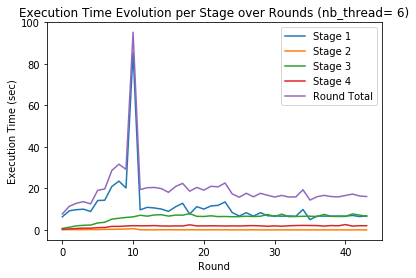

In [281]:
print('\nTotal execution time was', round(total_time, 1), 'seconds (', round(total_time/60, 1), 'mins)\n')

stage_time_dict[nb_thread] = (sum(t_hist_st1), sum(t_hist_st2), sum(t_hist_st3), sum(t_hist_st4))
total_time_dict[nb_thread] = total_time

print('With nb_thread=%d, Total execution time for each stage is, Stage1: %d, Stage2: %d, Stage3: %d, Stage4: %d' % (nb_thread, sum(t_hist_st1), sum(t_hist_st2), sum(t_hist_st3), sum(t_hist_st4)))

plt.plot(t_hist_st1, label='Stage 1')
plt.plot(t_hist_st2, label='Stage 2') 
plt.plot(t_hist_st3, label='Stage 3')
plt.plot(t_hist_st4, label='Stage 4')
plt.plot(t_hist_round, label='Round Total')

plt.title('Execution Time Evolution per Stage over Rounds (nb_thread= '+ str(nb_thread) + ')') 
plt.legend(loc='upper right')
plt.xlabel("Round")
plt.ylabel("Execution Time (sec)")
plt.savefig('./Data/Figures/Time_per_Stage_nb_thread' + str(nb_thread) + '.png')

In [282]:
print('stage_time_dict = ', stage_time_dict)
print('total_time_dict = ', total_time_dict)

stage_time_dict =  {6: (504.6535530090332, 6.192171096801758, 265.169038772583, 81.0676896572113), 5: (425.3946487903595, 6.164778470993042, 264.985004901886, 88.60664057731628), 4: (406.52807569503784, 6.528095960617065, 236.03210425376892, 82.96112656593323), 3: (586.6379969120026, 4.75326681137085, 382.6648168563843, 106.80774164199829), 2: (935.9590084552765, 5.649181365966797, 633.241316318512, 183.8122489452362), 1: (2272.0344178676605, 7.395992040634155, 778.6376185417175, 364.8658277988434)}
total_time_dict =  {6: 877.5945889949799, 5: 790.1284930706024, 4: 736.5315499305725, 3: 1104.0195088386536, 2: 1762.3882937431335, 1: 3504.687798023224}


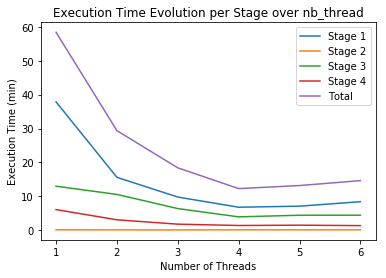

In [288]:
time_list_sorted = sorted(stage_time_dict.items(), key=lambda x: x[0], reverse=False)
total_time_list_sorted = sorted(total_time_dict.items(), key=lambda x: x[0], reverse=False)

x, y1, y2, y3, y4, y = [], [], [], [], [], []

for i in range(len(time_list_sorted)):
    x.append(str(time_list_sorted[i][0]))
    y1.append(time_list_sorted[i][1][0])
    y2.append(time_list_sorted[i][1][1])
    y3.append(time_list_sorted[i][1][2])
    y4.append(time_list_sorted[i][1][3])
    y.append(total_time_list_sorted[i][1])

y1_m, y2_m, y3_m, y4_m, y_m = np.array(y1)/60, np.array(y2)/60, np.array(y3)/60, np.array(y4)/60, np.array(y)/60

plt.plot(x, y1_m, label='Stage 1')
plt.plot(x, y2_m, label='Stage 2')
plt.plot(x, y3_m, label='Stage 3')
plt.plot(x, y4_m, label='Stage 4')
plt.plot(x, y_m, label='Total')
plt.title('Execution Time Evolution per Stage over nb_thread') 
plt.legend(loc='upper right')
plt.xlabel("Number of Threads")
plt.ylabel("Execution Time (min)")
plt.savefig('./Data/Figures/Time_per_Stage_over_nb_thread.png')

## 5. Conclusion

- Our algorithm has successfully detected the two communities in the benchmark network dataset.


- As per total execution times disclosed on graphs above, we observe a nice improvement of time saved in using parallelisation on threads. On most datasets, using 4 or 5 threads divide execution time by more than 3.


- Effects of parallelisation are mostly visible on the first stage of the algorithm, which is by far the most time-consuming, especially due to the reduce part at each iteration.


- Looking at the whole process, increasing the number of threads has almost a linear effect on execution time reduction for large networks.


- Whatever the size of the dataset we are working on, parallelisation of computations has significant impacts on time and indirectly on energy consumed. In order to process larger datasets (e.g. over than 1000 nodes and thousands of edges), it is recommended to use a Hadoop cluster (on such as AWS and Microsoft Azure) to run distributed computing over multiple workers.


- It is also possible to remove multiple edges (that have the highest edge betweenness scores) rather than only one edge per round, whose approximation technique permits us to significantly decrease the computation load.

## 6. References

1) S. Moon, et al., *"Parallel community detection on large graphs with MapReduce and GraphChi"*, Data Knowl. Eng. (2015)  

2) M.E. Newman, M. Girvan, *"Finding and evaluating community structure in networks"*, Phys. Rev. E 69 (2) (2004)  

3) V.D. Blondel, et al., *"Fast unfolding of communities in large networks"*, Journal of Statistical Mechanics: Theory and Experiment (2008)  

4) P. Pons and M. Latapy, *"Computing communities in large networks using random walks"*, J. Graph Algorithms Appl. (2005) 

5) R. Algesheimer, et al., *"A Comparative Analysis of Community Detection Algorithms on Artificial Networks"*, Nature (2016)  

## (Appendix) Notification Email (Temporal Section) 
- This is a code to send a notification email when all the rounds have finished.
- This section is to be deleted before submitting this notebook.

In [30]:
MY_PASSWORD = 'pass'

In [34]:
import smtplib, base64
from email.mime.text import MIMEText
from email.utils import formatdate
from email import encoders 

In [ ]:
# This code allows the notebook to send an email to inform us that all the rounds have been finished.
# Since we need to execute the whole code by changing nb_thread from 1 to 7 and each execution takes long time,
# we will benefit from this auto-notification code.

FROM_ADDRESS = 'a@gmail.com'
TO_ADDRESS = 'a@gmail.com'
BCC = None
SUBJECT = '[ELTDM] All Rounds with nb_thread = ' + str(nb_thread) + ' Done' 
BODY = 'This is to inform you that all the rounds with the number of threads ' + str(nb_thread)\
    + ' have finished. \nPlease check the result.\n'\
    + 'Figures are saved under file:///Users/IjiriYosuke/Documents/GitHub/ELTDM-Project/Data/Figures'\
    + '\n\n Maximum Q was achieved at round ' + str(r_best) + ', and it took '\
    + str(round(t_best, 1)) + ' seconds (' + str(round((t_best)/60, 1))\
    + 'mins) until the network reaches the best community structure.'\
    + '\nTotal execution time was ' + str(round(total_time, 1))\
    + ' seconds ( ' + str(round(total_time/60, 1)) + ' mins) \n\n'\
    + 'Current stage time dictionary is:\n' + str(stage_time_dict)\
    + '\nCurrent total time dictionary is:\n' + str(total_time_dict)\
    + 'stage_time_dict = ' + str(stage_time_dict)\
    + 'total_time_dict = ' + str(total_time_dict)\
    + '\n\n(This email is sent automatically)'

def create_message(from_addr, to_addr, bcc_addrs, subject, body):
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = from_addr
    msg['To'] = to_addr
    msg['Bcc'] = bcc_addrs
    msg['Date'] = formatdate()
    return msg

def send(from_addr, to_addrs, msg):
    smtpobj = smtplib.SMTP('smtp.gmail.com', 587)
    smtpobj.ehlo()
    smtpobj.starttls()
    smtpobj.ehlo()
    smtpobj.login(FROM_ADDRESS, MY_PASSWORD)
    smtpobj.sendmail(from_addr, to_addrs, msg.as_string())
    smtpobj.close()

if __name__ == '__main__':
    to_addr = TO_ADDRESS
    subject = SUBJECT
    body = BODY
    msg = create_message(FROM_ADDRESS, to_addr, BCC, subject, body)
    send(FROM_ADDRESS, to_addr, msg)
    
print('Email sent!')